In [1]:
import sys
import os
import time
import logging
import datetime
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt

# load dotenv
load_dotenv()

# configure logger
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s [%(name)s.%(funcName)s:%(lineno)d] %(message)s',
    datefmt='%d/%b/%Y %H:%M:%S'
    )
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## import local files if necessary
# sys.path.append('../GitHub/core-functions/src/dreams_core')
# import googlecloud as dgc2
# importlib.reload(dgc2)

# sys.path.append('../GitHub/etl-pipelines/coin_wallet_metrics')
# import coin_wallet_met?rics as wm
# importlib.reload(wm)

# production-ready code

In [2]:
query_sql = '''
    select * from analytics.bitcoin_prices
    '''
prices_df_full = dgc().run_sql(query_sql)
print(prices_df_full.info())
prices_df_full.head()

[07/Jun/2024 15:10:09] INFO [dreams_core.googlecloud.run_sql:84] BigQuery query completed.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055 entries, 0 to 4054
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   date        4055 non-null   datetime64[ns, UTC]
 1   price       4055 non-null   float64            
 2   market_cap  4054 non-null   float64            
 3   volume      4055 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 126.8 KB
None


,date,price,market_cap,volume
0,2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0


# code drafting workspace

In [51]:
def classify_price_action(prices_df_full, cutoff_date, window, price_activity_threshold, period_min_duration):
    """
    Calculate the period state for a given price DataFrame.

    Parameters:
        prices_df_full (pd.DataFrame): The full DataFrame containing date and price data.
        cutoff_date (str): The cutoff date in 'YYYY-MM-DD' format to filter the DataFrame.
        window (int): The window size for calculating rolling mean and standard deviation.
        price_activity_threshold (float): The average daily return threshold required for classifying \
            a period as Bullish or Bearish.
        period_min_duration (int): the number of days of bullish or bearish behavior to escape \
            classification as "Consolidation"

    Returns:
        pd.DataFrame: A DataFrame with an additional 'period' column classifying each row as 'Bullish', 'Bearish', or 'Consolidation'.
    """
    # 1. Calculate percentage changes within cutoff date
    # --------------------------------------------------
    prices_df = prices_df_full[prices_df_full['date'] >= cutoff_date].copy()

    # Calculate percentage changes
    prices_df['date'] = pd.to_datetime(prices_df['date'])
    prices_df.sort_values('date', inplace=True)
    prices_df['daily_pct_change'] = prices_df['price'].pct_change()

    # Calculate rolling mean percentage change
    prices_df['rolling_mean_long'] = prices_df['daily_pct_change'].rolling(window=window).mean()



    # 2. Classify long term and short term periodic price action
    # ----------------------------------------------------------
    # Long term periods
    def classify_period(row):
        if row['rolling_mean_long'] >= price_activity_threshold:
            return 'Bullish'
        elif row['rolling_mean_long'] <= -price_activity_threshold:
            return 'Bearish'
        else:
            return 'Consolidation'

    prices_df['period_long'] = prices_df.apply(classify_period, axis=1)

    # Short term periods
    prices_df['rolling_mean_short'] = prices_df['daily_pct_change'].rolling(window=3).mean()

    def classify_period(row):
        if row['rolling_mean_short'] >= price_activity_threshold*2:
            return 'Bullish'
        elif row['rolling_mean_short'] <= -price_activity_threshold*2:
            return 'Bearish'
        else:
            return 'Consolidation'

    prices_df['period_short'] = prices_df.apply(classify_period, axis=1)

    # 3. Classify overall price action based on long and short term behavior
    # ----------------------------------------------------------------------
    def determine_period(row):
        if row['period_long'] == 'Bullish':
            return 'Bullish'
        elif row['period_long'] == 'Bearish':
            return 'Bearish'
        elif row['period_long'] == 'Consolidation' and row['period_short'] == 'Bullish':
            return 'Bullish'
        elif row['period_long'] == 'Consolidation' and row['period_short'] == 'Bearish':
            return 'Bearish'
        else:
            return 'Consolidation'
        
    prices_df['period'] = prices_df.apply(determine_period, axis=1)

    # 4. Apply period_min_duration
    # ----------------------------
    # Add a column to calculate how long many days a period has extended
    prices_df['period_count'] = prices_df.groupby((prices_df['period'] != prices_df['period'].shift()).cumsum()).cumcount() + 1

    # Calculate the total duration of a given period
    prices_df['period_duration'] = prices_df.groupby((prices_df['period'] != prices_df['period'].shift()).cumsum())['period_count'].transform('max')

    # Convert any periods below period_min_duration to Consolidation
    prices_df['period_adj'] = prices_df['period']
    prices_df.loc[prices_df['period_duration'] < period_min_duration, 'period_adj'] = 'Consolidation'
    
    return prices_df


def graph_price_action(prices_df):
    """
    Graph the price action of a given DataFrame with color-coded periods.

    Parameters:
    prices_df (pd.DataFrame): The DataFrame containing date, price, and period data. 
                              Assumes 'date', 'price', and 'period' columns exist in the DataFrame.

    Returns:
    None
    """
    # Set colors for different periods
    colors = {'Bullish': 'green', 'Bearish': 'red', 'Consolidation': '#D3D3D3'}

    # Map the period to colors
    prices_df['color'] = prices_df['period_adj'].map(colors)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(21, 10))

    # Plot the price data with color coding based on the period
    ax.plot(prices_df['date'], prices_df['price'], color='blue', label='_nolegend_')

    # Apply color to line segments based on the period
    for i in range(len(prices_df) - 1):
        ax.plot(prices_df['date'].iloc[i:i+2], prices_df['price'].iloc[i:i+2], color=prices_df['color'].iloc[i])

    # Set the y-axis to log scale
    ax.set_yscale('log')

    # Add labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Bitcoin Price with Periods Highlighted')

    # Add a legend
    handles = [plt.Line2D([0], [0], color=color, label=label) for label, color in colors.items()]
    ax.legend(handles=handles)

    # Show the plot
    plt.show()



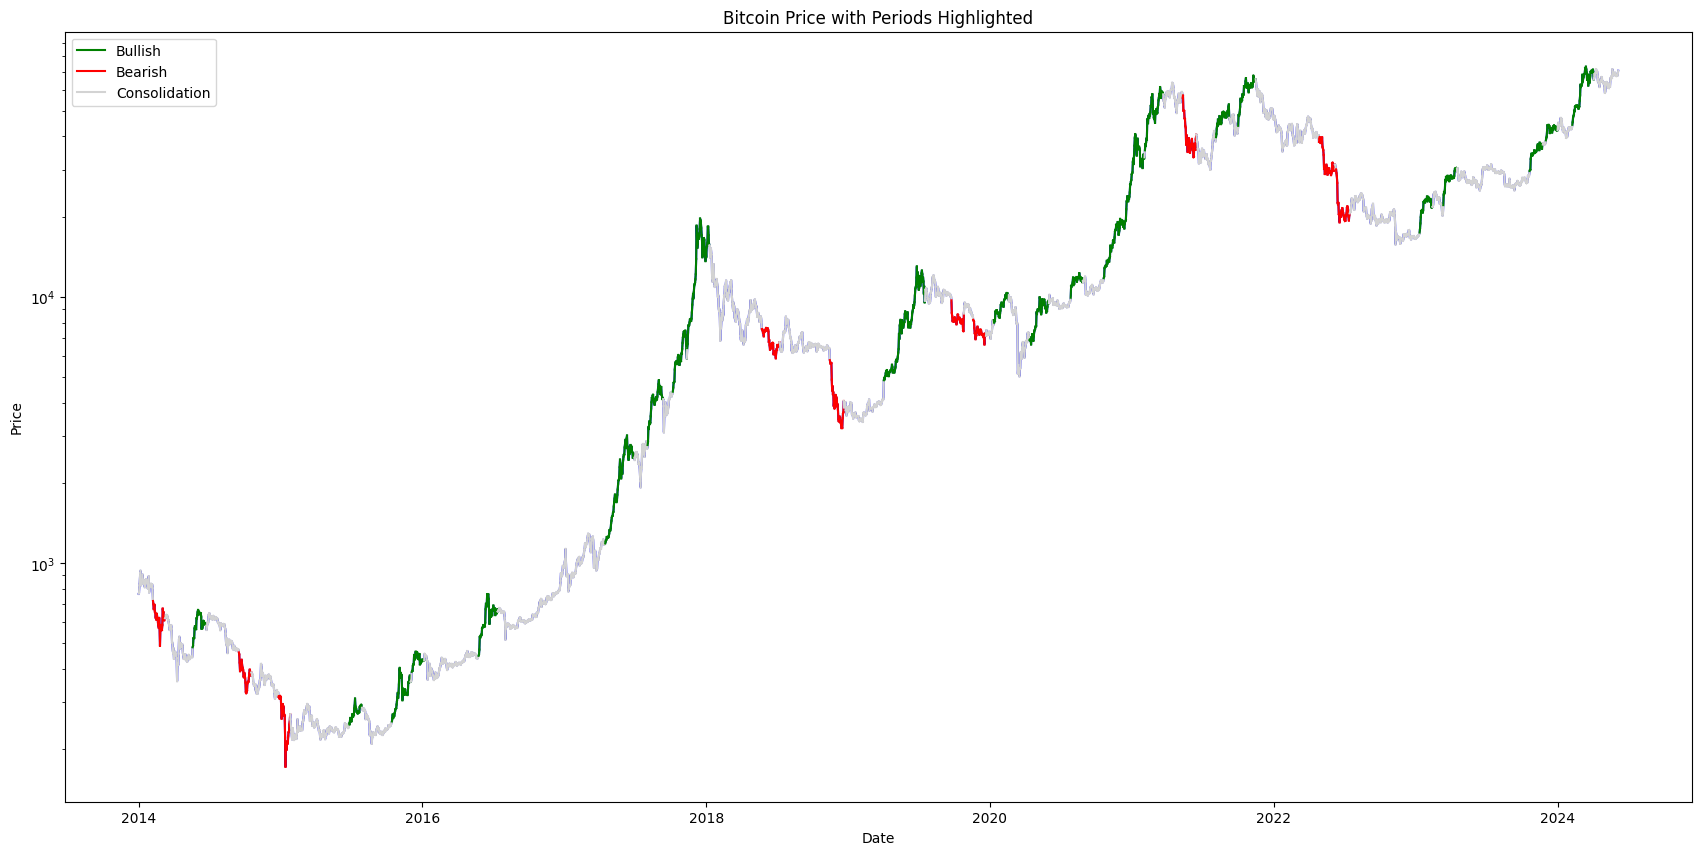

In [86]:
# Define the rolling window period
window = 30

# Define daily average change thresholds
price_activity_threshold = 0.0035

# cutoff date
cutoff_date = '2014-01-01'

# minimum length of bullish or bearish period
period_min_duration = 30

prices_df = classify_price_action(prices_df_full, cutoff_date, window, price_activity_threshold, period_min_duration)
graph_price_action(prices_df)
# prices_df.tail(20)

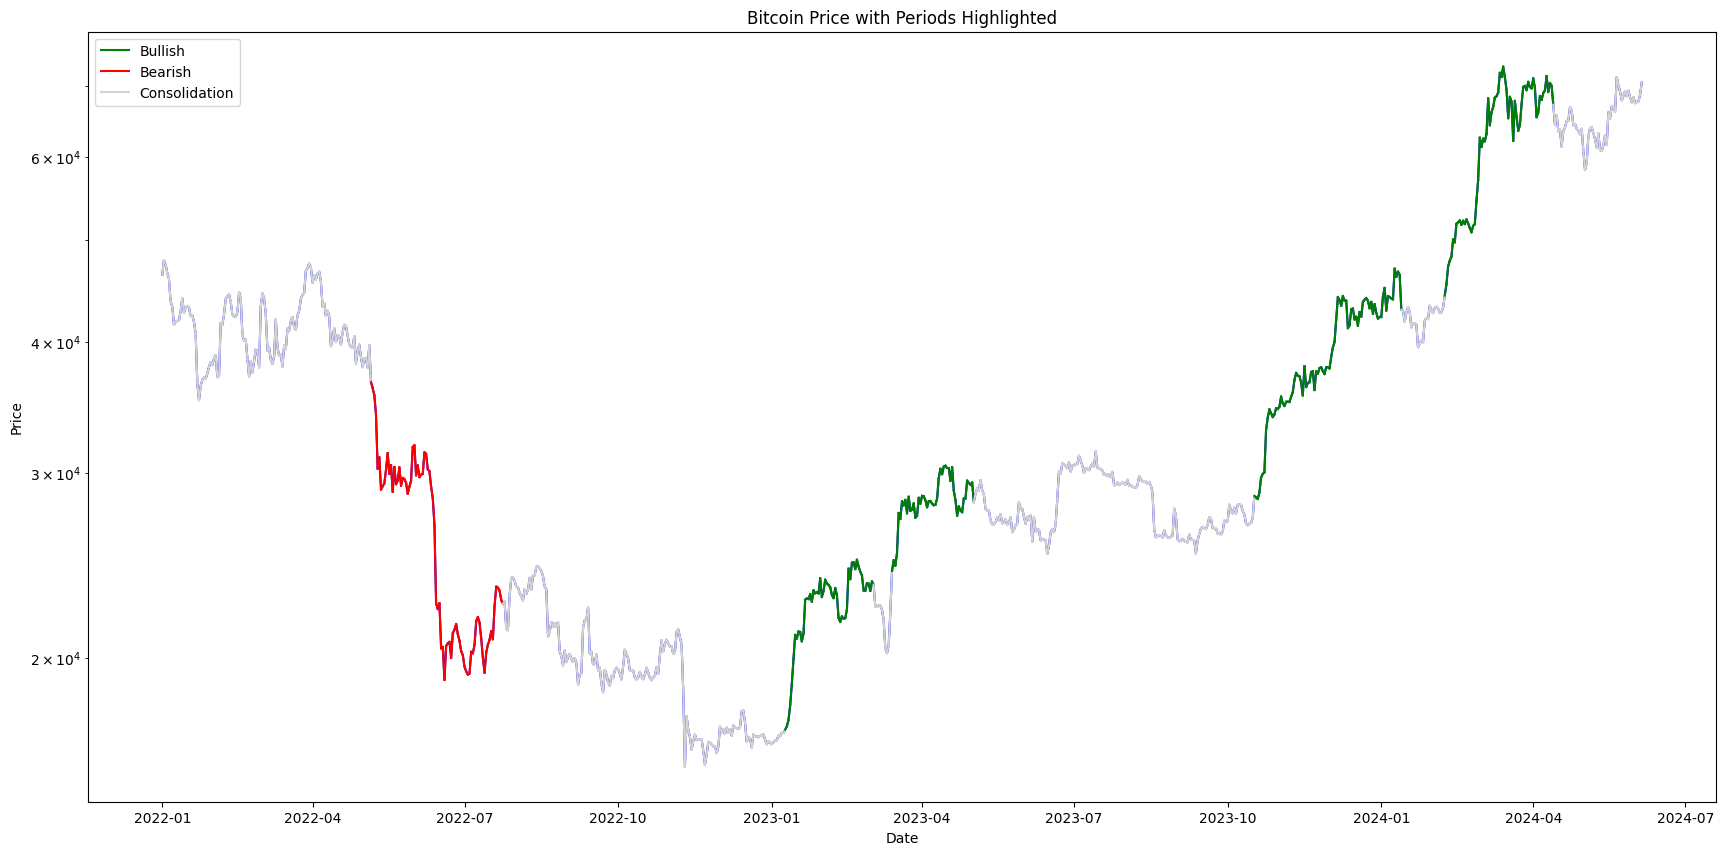

In [41]:
graph_price_action(prices_df)

In [21]:
pd.set_option('display.max_rows', 100)


start_date = '2024-02-01'
end_date = '2024-04-01'

prices_df[(prices_df['date'] >= start_date) & (prices_df['date'] <= end_date)]

,date,price,market_cap,volume,daily_pct_change,rolling_mean_long,rolling_std_long,period_long,rolling_mean_short,rolling_std_short,period_short,period,period_count,period_duration,period_adj
3929,2024-02-01 00:00:00+00:00,42583.263547,8.354214e+11,2.219794e+10,-0.007199,0.000855,0.025378,Consolidation,0.008735,0.021799,Bullish,Bullish,3,5,Consolidation
3930,2024-02-02 00:00:00+00:00,43069.043421,8.445852e+11,2.244368e+10,0.011408,0.000369,0.024925,Consolidation,0.011024,0.020989,Bullish,Bullish,4,5,Consolidation
3931,2024-02-03 00:00:00+00:00,43170.658562,8.465620e+11,1.862479e+10,0.002359,0.000380,0.024925,Consolidation,0.004477,0.013147,Bullish,Bullish,5,5,Consolidation
3932,2024-02-04 00:00:00+00:00,42976.848300,8.426685e+11,7.779819e+09,-0.004489,0.000763,0.024694,Consolidation,0.002960,0.013531,Consolidation,Consolidation,1,4,Consolidation
3933,2024-02-05 00:00:00+00:00,42599.359971,8.354164e+11,1.125081e+10,-0.008784,0.000466,0.024719,Consolidation,0.002021,0.014163,Consolidation,Consolidation,2,4,Consolidation
3934,2024-02-06 00:00:00+00:00,42648.456921,8.366309e+11,1.868228e+10,0.001153,0.000885,0.024545,Consolidation,-0.002033,0.007445,Consolidation,Consolidation,3,4,Consolidation
3935,2024-02-07 00:00:00+00:00,43087.787408,8.453937e+11,1.713111e+10,0.010301,0.000476,0.024205,Consolidation,0.000678,0.008052,Consolidation,Consolidation,4,4,Consolidation
3936,2024-02-08 00:00:00+00:00,44247.415415,8.686721e+11,2.120088e+10,0.026913,0.001218,0.024439,Consolidation,0.005552,0.011896,Bullish,Bullish,1,4,Consolidation
3937,2024-02-09 00:00:00+00:00,45338.271190,8.904682e+11,2.770961e+10,0.024654,0.001056,0.024252,Consolidation,0.007444,0.013872,Bullish,Bullish,2,4,Consolidation
3938,2024-02-10 00:00:00+00:00,47143.242991,9.255419e+11,4.199395e+10,0.039811,0.001753,0.024860,Consolidation,0.012794,0.018147,Bullish,Bullish,3,4,Consolidation


In [155]:
pd.set_option('display.max_rows', 100)


start_date = '2023-10-01'
end_date = '2024-01-01'

filtered_df = prices_df[(prices_df['date'] >= start_date) & (prices_df['date'] <= end_date)]

filtered_df

,date,price,market_cap,volume,daily_pct_change,rolling_mean_long,rolling_std_long,period_long,rolling_mean_short,rolling_std_short,period_short,period,period_count,period_duration,color
3806,2023-10-01 00:00:00+00:00,26969.876144,5.259363e+11,6.295435e+09,0.001957,-0.001542,0.019041,Consolidation,0.002172,0.011573,Consolidation,Consolidation,3,3,#D3D3D3
3807,2023-10-02 00:00:00+00:00,27967.510579,5.453021e+11,9.358227e+09,0.036991,-0.000812,0.019805,Consolidation,0.009200,0.015618,Bullish,Consolidation,1,4,#D3D3D3
3808,2023-10-03 00:00:00+00:00,27615.064885,5.383235e+11,1.812713e+10,-0.012602,-0.000978,0.019869,Consolidation,0.007133,0.017584,Bullish,Consolidation,2,4,#D3D3D3
3809,2023-10-04 00:00:00+00:00,27439.121947,5.356058e+11,1.267666e+10,-0.006371,-0.001184,0.019871,Consolidation,0.006733,0.017897,Bullish,Consolidation,3,4,#D3D3D3
3810,2023-10-05 00:00:00+00:00,27792.111277,5.419547e+11,1.087660e+10,0.012864,-0.000771,0.019945,Consolidation,0.007778,0.018029,Bullish,Consolidation,4,4,#D3D3D3
3811,2023-10-06 00:00:00+00:00,27435.874615,5.348516e+11,1.337619e+10,-0.012818,-0.000741,0.019926,Consolidation,0.002375,0.017670,Consolidation,Consolidation,1,1,#D3D3D3
3812,2023-10-07 00:00:00+00:00,27958.196437,5.451549e+11,1.381798e+10,0.019038,0.001206,0.016681,Consolidation,0.005580,0.018465,Bullish,Consolidation,1,2,#D3D3D3
3813,2023-10-08 00:00:00+00:00,27977.543491,5.456197e+11,7.226219e+09,0.000692,0.001566,0.016466,Consolidation,0.005399,0.018513,Bullish,Consolidation,2,2,#D3D3D3
3814,2023-10-09 00:00:00+00:00,27948.103652,5.449897e+11,7.141598e+09,-0.001052,0.001498,0.016470,Consolidation,-0.000036,0.012201,Consolidation,Consolidation,1,3,#D3D3D3
3815,2023-10-10 00:00:00+00:00,27593.782534,5.382827e+11,7.640030e+09,-0.012678,0.001201,0.016591,Consolidation,-0.000046,0.012214,Consolidation,Consolidation,2,3,#D3D3D3


In [149]:
jupyter nbextension enable --py --sys-prefix qgrid
jupyter nbextension enable --py --sys-prefix widgetsnbextension


SyntaxError: invalid syntax (809981300.py, line 1)

In [151]:
import qgrid
import pandas as pd

# Example DataFrame
data = {
    'A': [1, 2, 3, 4],
    'B': [5, 6, 7, 8],
    'C': [9, 10, 11, 12]
}
df = pd.DataFrame(data)

# Display DataFrame using qgrid
qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget


TypeError: register() missing 1 required positional argument: 'widget'

In [119]:
prices_df['period'] = prices_df.apply(
    lambda row: 'Consolidation' if row['period_long'] == 'Consolidation' and row['period_short'] == 'Consolidation' else (
        'Consolidation' if row['period_long'] != row['period_short'] else (
            'Bearish' if 'Bearish' in [row['period_long'], row['period_short']] else 'Bullish'
        )
    ), axis=1
)


prices_df['period'] = prices_df.apply(
    lambda row: 'Bearish' if 'Bearish' in [row['period_long'], row['period_short']] else (
        'Bullish' if 'Bullish' in [row['period_long'], row['period_short']] 
        else 'Consolidation'
    ), axis=1
)

prices_df[30:70]

prices_df[30:70]

,date,price,market_cap,volume,daily_pct_change,rolling_mean,rolling_std,period_long,period_short,period,period_count,period_duration,color
2467,2020-01-31 00:00:00+00:00,9509.805136,1.729931e+11,5.103778e+10,0.025107,0.017818,0.022242,Consolidation,Bullish,Bullish,3,7,#D3D3D3
2468,2020-02-01 00:00:00+00:00,9308.060286,1.693401e+11,5.010281e+10,-0.021214,0.014513,0.026339,Consolidation,Bullish,Bullish,4,7,#D3D3D3
2469,2020-02-02 00:00:00+00:00,9363.224207,1.703612e+11,4.830798e+10,0.005926,0.016773,0.024511,Consolidation,Bullish,Bullish,5,7,#D3D3D3
2470,2020-02-03 00:00:00+00:00,9338.416632,1.699266e+11,5.502540e+10,-0.002649,0.012167,0.024729,Consolidation,Bullish,Bullish,6,7,#D3D3D3
2471,2020-02-04 00:00:00+00:00,9308.912702,1.694070e+11,5.682477e+10,-0.003159,0.007002,0.023393,Consolidation,Bullish,Bullish,7,7,#D3D3D3
2472,2020-02-05 00:00:00+00:00,9179.959281,1.670754e+11,5.537766e+10,-0.013853,-0.002079,0.014812,Consolidation,Consolidation,Consolidation,1,3,#D3D3D3
2473,2020-02-06 00:00:00+00:00,9592.183874,1.745968e+11,6.567557e+10,0.044905,0.005009,0.022968,Consolidation,Consolidation,Consolidation,2,3,#D3D3D3
2474,2020-02-07 00:00:00+00:00,9744.636578,1.773883e+11,7.114170e+10,0.015893,0.003693,0.021862,Consolidation,Consolidation,Consolidation,3,3,#D3D3D3
2475,2020-02-08 00:00:00+00:00,9799.448456,1.784149e+11,6.949571e+10,0.005625,0.007527,0.018921,Consolidation,Bullish,Bullish,1,12,#D3D3D3
2476,2020-02-09 00:00:00+00:00,9890.701658,1.800816e+11,7.156180e+10,0.009312,0.008011,0.018917,Consolidation,Bullish,Bullish,2,12,#D3D3D3


In [96]:
# Add a column to calculate consecutive periods
prices_df['period_count'] = prices_df.groupby((prices_df['period'] != prices_df['period'].shift()).cumsum()).cumcount() + 1


# Add a column to calculate the duration of each period
prices_df['period_duration'] = prices_df.groupby((prices_df['period'] != prices_df['period'].shift()).cumsum())['period_count'].transform('max')


prices_df[30:70]

,date,price,market_cap,volume,daily_pct_change,rolling_mean,rolling_std,period,color,period_count,period_duration
2467,2020-01-31 00:00:00+00:00,9509.805136,1.729931e+11,5.103778e+10,0.025107,NaN,NaN,Consolidation,#D3D3D3,31,50
2468,2020-02-01 00:00:00+00:00,9308.060286,1.693401e+11,5.010281e+10,-0.021214,NaN,NaN,Consolidation,#D3D3D3,32,50
2469,2020-02-02 00:00:00+00:00,9363.224207,1.703612e+11,4.830798e+10,0.005926,NaN,NaN,Consolidation,#D3D3D3,33,50
2470,2020-02-03 00:00:00+00:00,9338.416632,1.699266e+11,5.502540e+10,-0.002649,NaN,NaN,Consolidation,#D3D3D3,34,50
2471,2020-02-04 00:00:00+00:00,9308.912702,1.694070e+11,5.682477e+10,-0.003159,NaN,NaN,Consolidation,#D3D3D3,35,50
2472,2020-02-05 00:00:00+00:00,9179.959281,1.670754e+11,5.537766e+10,-0.013853,NaN,NaN,Consolidation,#D3D3D3,36,50
2473,2020-02-06 00:00:00+00:00,9592.183874,1.745968e+11,6.567557e+10,0.044905,NaN,NaN,Consolidation,#D3D3D3,37,50
2474,2020-02-07 00:00:00+00:00,9744.636578,1.773883e+11,7.114170e+10,0.015893,NaN,NaN,Consolidation,#D3D3D3,38,50
2475,2020-02-08 00:00:00+00:00,9799.448456,1.784149e+11,6.949571e+10,0.005625,NaN,NaN,Consolidation,#D3D3D3,39,50
2476,2020-02-09 00:00:00+00:00,9890.701658,1.800816e+11,7.156180e+10,0.009312,NaN,NaN,Consolidation,#D3D3D3,40,50
